# Evaluate model for Vietnamese Stock Env

In [1]:
import vectorbt as vbt
import gymnasium as gym
from stock_env.common.common_utils import create_performance, plot_trade_log_v2
from stock_env.envs import *
from stock_env.common.evaluation import evaluate_agent, play_an_episode
from stock_env.algos.agent import Agent
import torch as th

# Evaluation

## Evaluation on random period

In [2]:
envs = gym.vector.make('SP500-v0', num_envs=1, asynchronous=False)
agent = Agent(envs)
agent.load_state_dict(th.load('/Users/manbnm/stock-env/model/SP500-v0_ppo_2022-12-05_21-49-34.pth'))
agent.eval()

Agent(
  (critic): Sequential(
    (0): Linear(in_features=70, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor_mean): Sequential(
    (0): Linear(in_features=70, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [3]:
mean, std = evaluate_agent(agent, envs, n_eval_episodes=10)
print(f"Mean reward: {mean:.2f} +/- {std: .2f}")

Mean reward: -827.79 +/-  380.36


# Evaluation on specific stock

In [4]:
envs = gym.vector.make('SP500-v0', num_envs=1, asynchronous=False)
# run model to get detailed information in the enviroment
info = play_an_episode(agent, envs)
df =  info['final_info'][0]['final_history']
df.head()

,time,open,high,low,close,volume,ticker_x,quantity,actions,delta_shares,portfolio_value,nav,cash,step_reward,ticker_y
0,2012-08-29 00:00:00-04:00,36.009998,36.470001,35.639999,32.681911,390800.0,DPZ,100,0.790071,100,19663.590315,3268.191147,16395.399168,-2.0,DPZ
1,2012-08-30 00:00:00-04:00,36.060001,36.250000,35.529999,32.122025,242100.0,DPZ,200,0.498694,100,19210.197938,6424.404907,12785.793031,-2.0,DPZ
2,2012-08-31 00:00:00-04:00,35.790001,35.950001,35.320000,32.004608,232700.0,DPZ,400,0.291060,200,18422.478109,12801.843262,5620.634847,-2.0,DPZ
3,2012-09-04 00:00:00-04:00,35.380001,35.990002,34.869999,32.275543,351900.0,DPZ,500,0.062230,100,18216.868347,16137.771606,2079.096740,-2.0,DPZ
4,2012-09-05 00:00:00-04:00,35.639999,35.840000,35.320000,31.905287,364400.0,DPZ,500,0.201420,0,18031.740135,15952.643394,2079.096740,-2.0,DPZ



    Annual return     :  7.15%
    Cumulative return :  14.69%
    Sharpe ratio      :  0.39
    Maximum Drawdown  : -16.56%
    Annual Volatility :  52.10%
    Value-At-Risk     :  nan%
    


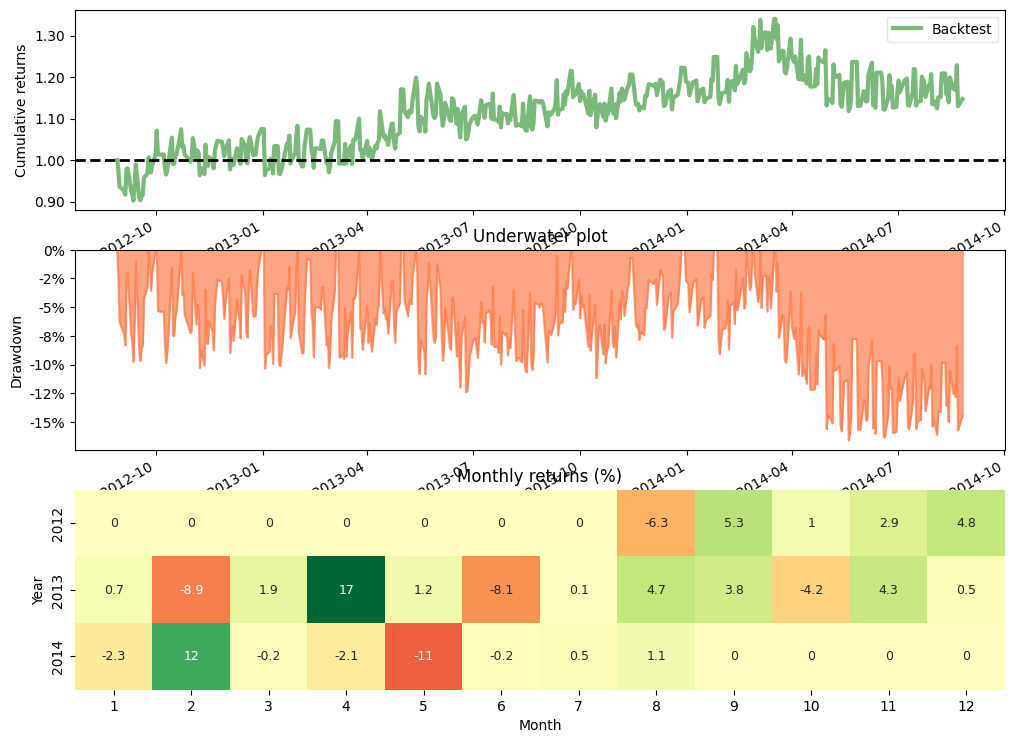

In [5]:
returns = df.set_index('time')['portfolio_value'].pct_change()
create_performance(returns)

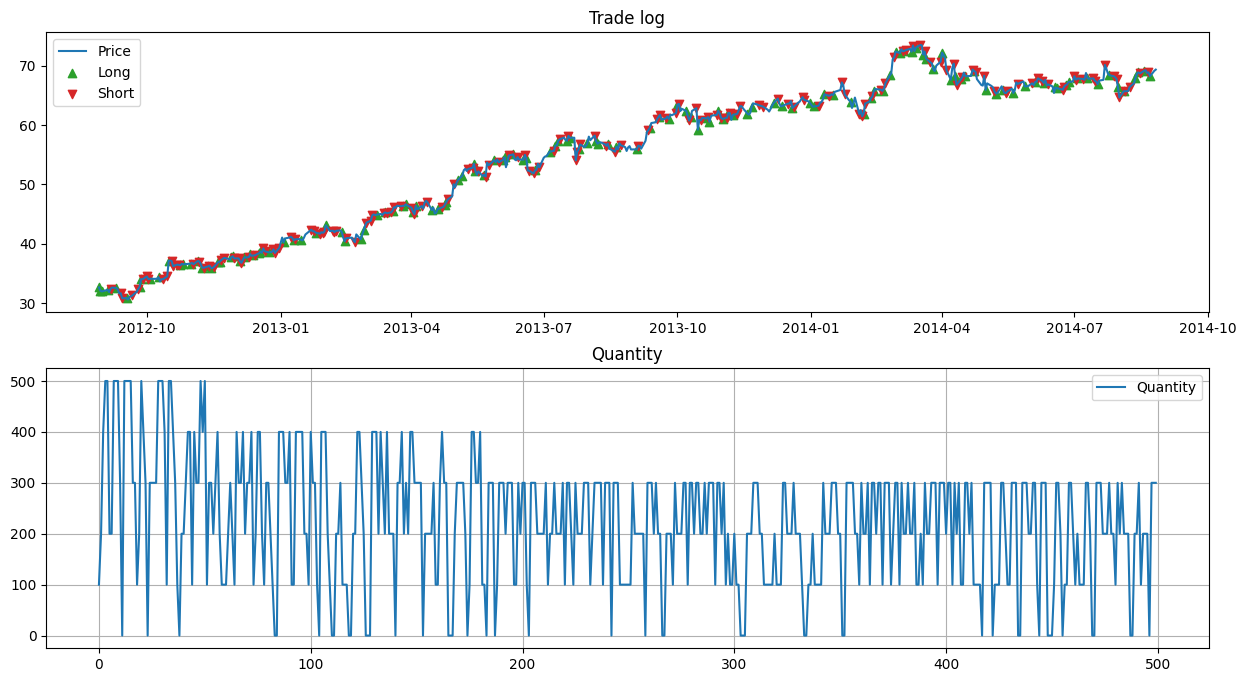

In [6]:
plot_trade_log_v2(df)

# Compare with buy-and-hold strategy and feature strategy

In [7]:
# portfolio value from hodling
df['pv_from_holding'] = vbt.Portfolio.from_holding(df.close, init_cash=20e3).value()

In [8]:
fig = df['portfolio_value'].vbt.plot_against(df['pv_from_holding'])
fig.show()